In [ ]:
!nvidia-smi


Wed Aug 16 18:34:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:01:00.0  On |                  N/A |
| N/A   60C    P5    25W /  N/A |    692MiB / 16125MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# <font color = 'pickle'>**Summarization-Abstractive** </font>







## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Exploring and Understanding IMDB Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Prediction and Evaluation**: Evaluate model on test set and making predictions.



# <font color = 'pickle'> **Setting up the Environment** </font>

In [ ]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate py7zr rouge_score sentencepiece - U - qq

    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


# <font color = 'pickle'> **Exploring and Understanding Dataset**

## <font color = 'pickle'> **SAMSum Dataset**</font>

The SAMSum dataset, developed by Samsung, is a dataset specifically designed for abstractive text summarization of conversational data. It consists of a collection of dialogues along with brief summaries. Most of the datasets for text summarization available before SAMSum were focused on summarizing articles, papers, or other long-form content. However, the SAMSum dataset targets the summarization of dialogues, which has its own unique challenges and characteristics.

Here are some key points about the SAMSum dataset:

1. **Dialogues Data**: The dataset consists of dialogues and their corresponding abstractive summaries. This is in contrast to most other summarization datasets, which contain news articles or scientific papers.
  
2. **Size**: The SAMSum corpus contains thousands of dialogues, making it a substantial resource for training and testing summarization models on conversational data.
  
 4. **Source**: The dialogues in SAMSum are based on real-life conversations but have been anonymized and altered to protect privacy and for clarity.
  
5. **Application**: In an enterprise setting, these dialogues might represent the interactions between a customer and the support center. Therefore, generating accurate summaries can help improve customer service and detect common patterns among customer requests. It's also useful for developing models that can generate summaries for chatbot conversations and other conversational platforms.
  
6. **Format**: Each dialogue in the dataset is presented as a series of turns between two participants, followed by a human-written summary capturing the main points of the conversation.






## <font color = 'pickle'> **Load Data set**
    


In [ ]:
from datasets import load_dataset, DatasetDict


In [ ]:
samsum_dataset = load_dataset("samsum")


## <font color = 'pickle'> **Understanding your data**

In [ ]:
print(samsum_dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})


## <font color = 'pickle'> **Understanding the datatype of columns**


In [ ]:
samsum_dataset["train"].features


{'id': Value(dtype='string', id=None),
 'dialogue': Value(dtype='string', id=None),
 'summary': Value(dtype='string', id=None)}

 Code Explanation:

 The code samsum_dataset['train'].features returns a description of the features (columns and their data types) present in the training split of the samsum dataset.

All the columns are of string data type. You will know access one example to understand the data better.



## <font color = 'pickle'> **Acess indivdual element** </font>
 The dataset behaves like an Python array or list. We can use the familiar indexing/slicing methods to access individual elements.

In [ ]:
# get the first example of the dataset
samsum_dataset["train"][0]


{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

The dialogues resemble typical SMS or WhatsApp chats, complete with emojis and spaces for GIFs. The "dialogue" field presents the entire text, while the "summary" field provides the summary of the conversation.

## <font color = 'pickle'> **Exploratory Data Analysis (EDA)**

### <font color = 'pickle'> **Change dataset format to Pandas**  </font>


In [ ]:
# This will convert all the splits into Pandas dataframe
samsum_dataset.set_format(type="pandas")


In [ ]:
# Get all rows from training split
df_train = samsum_dataset["train"][:]


In [ ]:
df_train.head()


,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


In [ ]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14732 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB


### <font color = 'pickle'> **Check length of the dialogue/summary** </font>


In [ ]:
df_train["words_per_summary"] = df_train["summary"].str.split().apply(len)
df_train["words_per_dialogue"] = df_train["dialogue"].str.split().apply(len)


In [ ]:
df_train.head()


,id,dialogue,summary,words_per_summary,words_per_dialogue
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,9,16
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,10,18
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,14,98
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,18,26
4,13728094,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...",27,179


#### <font color = 'pickle'> **Plot the distribution of review length** </font>

In [ ]:
import matplotlib.pyplot as plt


def plot_two_hists(series1, series2, label1, label2):
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the first histogram on the left subplot
    axs[0].hist(series1, bins=50, edgecolor="black")
    axs[0].set_xlabel("Number of Words")
    axs[0].set_ylabel("Frequency")
    axs[0].set_title(f"Distribution of Words per {label1}")

    # Plot the second histogram on the right subplot
    axs[1].hist(series2, bins=50, edgecolor="black")
    axs[1].set_xlabel("Number of Words")
    axs[1].set_ylabel("Frequency")
    axs[1].set_title(f"Distribution of Words per {label2}")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3)

    # Display the plot
    plt.show()


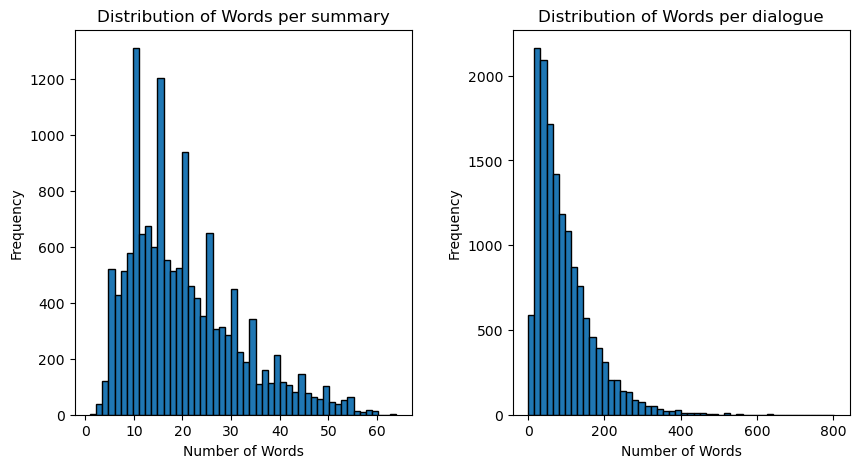

In [ ]:
plot_two_hists(
    df_train["words_per_summary"], df_train["words_per_dialogue"], "summary", "dialogue"
)


In [ ]:
df_train["words_per_dialogue"].describe()


count    14732.000000
mean        93.786383
std         74.033457
min          0.000000
25%         39.000000
50%         73.000000
75%        128.000000
max        803.000000
Name: words_per_dialogue, dtype: float64

In [ ]:
# Let us check how many dialogues has more than 500 words

count = (df_train["words_per_dialogue"] > 500).sum()
print(f"Number of reviews with more than 400 words: {count}")


Number of reviews with more than 400 words: 19


From the above graph, it seems that the distribution of number of words is similar for positive and negative reviews.

### <font color = 'pickle'> **Reset dataset format** </font>


In [ ]:
samsum_dataset.reset_format()


In [ ]:
samsum_dataset


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

# <font color = 'pickle'> **Data Pre-processing**</font>

## <font color = 'pickle'> **Accessing and Manuplating Splits**</font>


### <font color = 'pickle'> **Extract Splits**

In [ ]:
train_split = samsum_dataset["train"]
valid_split = samsum_dataset["validation"]
test_split = samsum_dataset["test"]


In [ ]:
train_split


Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 14732
})

### <font color = 'pickle'> **Create subset for experimentation** </font>

In [ ]:
train_split_small = train_split.shuffle(seed=42).select(range(500))
val_split_small = valid_split.shuffle(seed=42).select(range(100))
test_split_small = test_split.shuffle(seed=42).select(range(100))


### <font color = 'pickle'> **Combine splits**</font>
Some times we will need to combine different splits to one dataset. This is very useful when we have to apply the same pre-processing to all the splits.
In our example, we will combine train and validation splits as we will be applying the same processing steps to both the splits.


In [ ]:
train_val = DatasetDict(
    {"train": samsum_dataset["train"], "valid": samsum_dataset["validation"]}
)
train_val_small = DatasetDict(
    {"train": train_split_small, "valid": val_split_small})


In [ ]:
train_val_small


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 500
    })
    valid: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 100
    })
})

In [ ]:
train_val_small["train"]["dialogue"][0]


'Lucy: omg did you see JK this morning?\r\nSue: I try to avoid it lol\r\nLucy: you should have seen it it was disgusting\r\nSue: I cant do it anymore i try to listen to the radio in the mornings.. jk makes you think the whole world is full of idiots lol\r\nLucy: you may be right I dont know how some of them can go on there in public for the world to see\r\nSue: I would die if I got a call to go on there lol\r\nSue: could you imagine ha ha \r\nLucy: I would piss myself If I saw you and Andy up there\r\nSue: over my dead body !'

In [ ]:
train_val_small["train"]["summary"][0]


"Sue doesn't watch JK any more as it's disgusting."

In [ ]:
train_val_small["train"]["dialogue"][1]


"Wendy: What's up?\r\nSimon: Nothing much. I'm painting my cupboards. \r\nAngela: Cool what colour?\r\nSimon: Green.\r\nBen: I'm just chilling in the garden. \r\nAngela: Nice weekend! I'm about to meet Chris.\r\nWendy: Say hello from me!\r\nAngela: Will do! And how is your weekend, Wendy?\r\nWendy: Very lazy... The week was hard at work, I really needed some rest. \r\nBen: We should all come and visit Simon in his new apartment!\r\nSimon: You are welcome, guys! Whenever you wish.\r\nBen: I should be in Bournemouth next week. \r\nSimon: I'm not going anywhere :-)\r\nBen: Cool, I'll call you next week. "

In [ ]:
train_val_small["train"]["summary"][1]


'This weekend Wendy is very lazy because she worked hard at work, and Angela is meeting Chris. Simon is chilling in the garden and painting his cupboards green. Next week, Ben, Angela, Chris and Wendy will visit him in his new apartament.'

## <font color = 'pickle'> **Tokenization**</font>

###  <font color = 'pickle'> **Load pre-trained Tokenizer** </font>

In [ ]:
from transformers import AutoTokenizer

checkpoint = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


### <font color = 'pickle'> **Understanding Sentence-piece tokenizers**</font>

In [ ]:
text = [
    "Tokenization is the process of splitting sequence to tokens",
    "I like BUAN6482",
]


In [ ]:
# get the vocab size
print(f"Pretrained tokenizer vocab size {tokenizer.vocab_size}")


Pretrained tokenizer vocab size 96103


In [ ]:
encoded_text = tokenizer(
    text, padding=True, truncation=True, return_tensors="pt")


In [ ]:
encoded_text


{'input_ids': tensor([[32487,  3884,   117,   109,   366,   113, 20186,  5936,   112, 14426,
             1],
        [  125,   172,   596, 77083, 46752,   522,     1,     0,     0,     0,
             0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}

In [ ]:
tokens_first_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[0])
tokens_second_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[1])

print(tokens_first_sentence)
print(tokens_second_sentence)


['▁Token', 'ization', '▁is', '▁the', '▁process', '▁of', '▁splitting', '▁sequence', '▁to', '▁tokens', '</s>']
['▁I', '▁like', '▁B', 'UAN', '648', '2', '</s>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
tokenizer.convert_tokens_to_string(tokens_first_sentence)


'Tokenization is the process of splitting sequence to tokens</s>'

In [ ]:
special_tokens = tokenizer.all_special_tokens
special_tokens_ids = tokenizer.all_special_ids


In [ ]:
import pandas as pd


In [ ]:
df = pd.DataFrame(
    {"special_tokens": special_tokens, "special_tokens_ids": special_tokens_ids}
)


In [ ]:
pd.set_option("display.max_rows", None)


In [ ]:
df


,special_tokens,special_tokens_ids
0,</s>,1
1,<unk>,105
2,<pad>,0
3,<mask_2>,3
4,<mask_1>,2
5,<unk_2>,4
6,<unk_3>,5
7,<unk_4>,6
8,<unk_5>,7
9,<unk_6>,8


###  <font color = 'pickle'> **Create function for Tokenizer**

In [ ]:
# we do not need to add padding
# padding and conversion to Pytorch Tensor is handled by the data collators
# in more efficient manner (explained later)


def tokenize_fn(batch):
    input_encodings = tokenizer(
        batch["dialogue"], truncation=True, max_length=1024)

    target_encodings = tokenizer(
        text_target=batch["summary"], truncation=True, max_length=128
    )

    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"],
    }


###  <font color = 'pickle'> **Use map function to apply tokenization to all splits**

In [ ]:
tokenized_dataset = train_val.map(tokenize_fn, batched=True)


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_small = train_val_small.map(tokenize_fn, batched=True)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_small


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    valid: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

We can see that tokenization step has added three new columns ('input_ids', 'token_type_ids', 'attention_mask') to the dataset

In [ ]:
tokenized_dataset_small = tokenized_dataset_small.remove_columns(
    train_val_small["train"].column_names
)
tokenized_dataset = tokenized_dataset.remove_columns(
    train_val_small["train"].column_names
)


In [ ]:
tokenized_dataset_small.set_format(type="torch")
tokenized_dataset.set_format(type="torch")


In [ ]:
tokenized_dataset_small


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [ ]:
tokenized_dataset_small["train"].features


{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
print(len(tokenized_dataset_small["train"]["input_ids"][2]))
print(len(tokenized_dataset_small["train"]["input_ids"][1]))


100
149


In [ ]:
print(
    tokenizer.convert_ids_to_tokens(
        tokenized_dataset_small["train"]["input_ids"][0][0:10]
    )
)


['▁Lucy', ':', '▁om', 'g', '▁did', '▁you', '▁see', '▁JK', '▁this', '▁morning']


In [ ]:
print(
    tokenizer.convert_ids_to_tokens(
        tokenized_dataset_small["train"]["labels"][0][0:10])
)


['▁Sue', '▁doesn', "'", 't', '▁watch', '▁JK', '▁any', '▁more', '▁as', '▁it']


#  <font color = 'pickle'> **Model Training**

##  <font color = 'pickle'> **Model Config File**</font>



In [ ]:
from transformers import AutoConfig


In [ ]:
config = AutoConfig.from_pretrained(checkpoint)


In [ ]:
config


PegasusConfig {
  "_name_or_path": "google/pegasus-cnn_dailymail",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "length_penalty": 0.8,
  "max_length": 128,
  "max_position_embeddings": 1024,
  "min_length": 3

In [ ]:
from transformers import GenerationConfig

# generation_config = GenerationConfig.from_model_config(config)
generation_config = GenerationConfig.from_pretrained(checkpoint)


In [ ]:
generation_config


GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.31.0"
}

##  <font color = 'pickle'> **Download pre-trained model**

In [ ]:
from transformers import AutoModelForSeq2SeqLM


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    checkpoint,
    config=config,
)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## <font color = 'pickle'> **Model Input/Collate Function** </font>

In [ ]:
from transformers import DataCollatorForSeq2Seq


In [ ]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
)


In [ ]:
train_val_small['train'][0]


{'id': '13681220',
 'dialogue': 'Lucy: omg did you see JK this morning?\r\nSue: I try to avoid it lol\r\nLucy: you should have seen it it was disgusting\r\nSue: I cant do it anymore i try to listen to the radio in the mornings.. jk makes you think the whole world is full of idiots lol\r\nLucy: you may be right I dont know how some of them can go on there in public for the world to see\r\nSue: I would die if I got a call to go on there lol\r\nSue: could you imagine ha ha \r\nLucy: I would piss myself If I saw you and Andy up there\r\nSue: over my dead body !',
 'summary': "Sue doesn't watch JK any more as it's disgusting."}

In [ ]:
features = [tokenized_dataset_small["train"][i] for i in range(2)]
features


[{'input_ids': tensor([12174,   151, 25479,   838,   368,   119,   236, 36844,   136,  1039,
            152, 12776,   151,   125,   508,   112,  1405,   126, 10898, 12174,
            151,   119,   246,   133,   684,   126,   126,   140, 27383, 12776,
            151,   125,   137,   144,   171,   126,  4288,   532,   508,   112,
           2427,   112,   109,  2413,   115,   109, 13770,   107,   107,   110,
          53724,   493,   119,   311,   109,   664,   278,   117,   357,   113,
          48310, 10898, 12174,   151,   119,   218,   129,   268,   125,  7532,
            235,   199,   181,   113,   183,   137,   275,   124,   186,   115,
            481,   118,   109,   278,   112,   236, 12776,   151,   125,   192,
           2696,   175,   125,   419,   114,   443,   112,   275,   124,   186,
          10898, 12776,   151,   256,   119,  2925,  8886,  8886, 12174,   151,
            125,   192, 48696,  1150,   240,   125,  1148,   119,   111,  7441,
            164,   186, 127

In [ ]:
model_input = data_collator(features)
model_input.keys()


dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [ ]:
print(model_input.input_ids[0][0:10])
print(model_input.input_ids[0][-20:])
print(model_input.input_ids[1][0:10])
print(model_input.input_ids[1][-20:])


tensor([12174,   151, 25479,   838,   368,   119,   236, 36844,   136,  1039])
tensor([147,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0])
tensor([17472,   151,   463,   131,   116,   164,   152,  6331,   151,  6490])
tensor([  125,   131,   208,   146,   313,  2240, 29344,  3703,   151,  7262,
          108,   125,   131,   267,   443,   119,   352,   396,   107,     1])


In [ ]:
print(model_input.attention_mask[0][-20:])
print(model_input.attention_mask[1][-20:])


tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
print(model_input.labels[0][0:10])
print(model_input.labels[0][-20:])
print(model_input.labels[1][0:10])
print(model_input.labels[1][-20:])


tensor([12776,   591,   131,   144,  1183, 36844,   189,   154,   130,   126])
tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100])
tensor([  182,  1339, 17472,   117,   221,  9474,   262,   265,   947,   514])
tensor([ 3516,   396,   108,  3703,   108, 14058,   108,  3292,   111, 17472,
          138,   558,   342,   115,   169,   177,  2971, 42745,   107,     1])


In [ ]:
print(model_input.decoder_input_ids[0][0:10])
print(model_input.decoder_input_ids[0][-20:])
print(model_input.decoder_input_ids[1][0:10])
print(model_input.decoder_input_ids[1][-20:])


tensor([    0, 12776,   591,   131,   144,  1183, 36844,   189,   154,   130])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([    0,   182,  1339, 17472,   117,   221,  9474,   262,   265,   947])
tensor([  107,  3516,   396,   108,  3703,   108, 14058,   108,  3292,   111,
        17472,   138,   558,   342,   115,   169,   177,  2971, 42745,   107])


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.decoder_input_ids[0][0:10]))
print(tokenizer.convert_ids_to_tokens(model_input.labels[0][0:10]))


['<pad>', '▁Sue', '▁doesn', "'", 't', '▁watch', '▁JK', '▁any', '▁more', '▁as']
['▁Sue', '▁doesn', "'", 't', '▁watch', '▁JK', '▁any', '▁more', '▁as', '▁it']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.decoder_input_ids[0][-20:]))
try:
    print(tokenizer.convert_ids_to_tokens(model_input.labels[0][-20:]))
except:
    print(f"No tokens corresponding to ids")


['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
No tokens corresponding to ids


##  <font color = 'pickle'> **Understanding Model Output**


In [ ]:
# model output
model_output = model(**model_input)


In [ ]:
# keys in model output
model_output.keys()


odict_keys(['loss', 'logits', 'encoder_last_hidden_state'])

In [ ]:
# let us look at logits
model_output.logits.shape


torch.Size([2, 51, 96103])

In [ ]:
model_input.keys()


dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [ ]:
# generate prediction from logits using beam search
generated_predictions = model.generate(
    **model_input, generation_config=generation_config, max_length=128
)


In [ ]:
generated_predictions.shape


torch.Size([2, 52])

In [ ]:
generated_predictions


tensor([[    0, 12776,   591,   131,   144,  1183, 36844,   189,   154,   130,
           126,   131,   116, 27383,   107,     1,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     1],
        [    0,   182,  1339, 17472,   117,   221,  9474,   262,   265,   947,
           514,   134,   201,   108,   111, 14058,   117,   988,  3292,   107,
          6331,   117, 23290,   115,   109,  1484,   111,  2528,   169, 22507,
          1190,   107,  3516,   396,   108,  3703,   108, 14058,   108,  3292,
           111, 17472,   138,   558,   342,   115,   169,   177,  2971, 42745,
           107,     1]])

In [ ]:
generated_predictions.shape


torch.Size([2, 52])

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(generated_predictions[0])
print(tokens)


['<pad>', '▁Sue', '▁doesn', "'", 't', '▁watch', '▁JK', '▁any', '▁more', '▁as', '▁it', "'", 's', '▁disgusting', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


In [ ]:
summary = tokenizer.convert_tokens_to_string(tokens)
print(summary)


<pad> Sue doesn't watch JK any more as it's disgusting.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad></s>


In [ ]:
tokenizer.decode(generated_predictions[1])


'<pad> This weekend Wendy is very lazy because she worked hard at work, and Angela is meeting Chris. Simon is chilling in the garden and painting his cupboards green. Next week, Ben, Angela, Chris and Wendy will visit him in his new apartament.</s>'

In [ ]:
tokenizer.decode(generated_predictions[1], skip_special_tokens=True)


'This weekend Wendy is very lazy because she worked hard at work, and Angela is meeting Chris. Simon is chilling in the garden and painting his cupboards green. Next week, Ben, Angela, Chris and Wendy will visit him in his new apartament.'

In [ ]:
# decode tokens to generate summary
tokenizer.batch_decode(generated_predictions)


["<pad> Sue doesn't watch JK any more as it's disgusting.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad></s>",
 '<pad> This weekend Wendy is very lazy because she worked hard at work, and Angela is meeting Chris. Simon is chilling in the garden and painting his cupboards green. Next week, Ben, Angela, Chris and Wendy will visit him in his new apartament.</s>']

In [ ]:
# decode tokens to generate summary
tokenizer.batch_decode(generated_predictions, skip_special_tokens=True)


["Sue doesn't watch JK any more as it's disgusting.",
 'This weekend Wendy is very lazy because she worked hard at work, and Angela is meeting Chris. Simon is chilling in the garden and painting his cupboards green. Next week, Ben, Angela, Chris and Wendy will visit him in his new apartament.']

##  <font color = 'pickle'> **Evaluation metric(s)** </font>

###  <font color = 'pickle'> **Understanding Rogue** </font>

In [ ]:
import nltk
nltk.download("punkt")


[nltk_data] Downloading package punkt to /home/harpreet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import sent_tokenize
import evaluate
rouge_score = evaluate.load("rouge")


###  <font color = 'pickle'> **Understanding BLUE** </font>

### <font color = 'pickle'> **Function to compute metric** </font>


In [ ]:
from nltk.tokenize import sent_tokenize
import evaluate
import numpy as np

In [ ]:
rouge_score = evaluate.load("rouge")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    # Separate predictions and labels
    predictions, labels = eval_pred

    # Decode generated summaries into text, removing any special tokens
    decoded_predictions = tokenizer.batch_decode(
        predictions, skip_special_tokens=True)

    # Replace -100 in the labels with padding token ID, as -100 is commonly used to indicate ignored tokens
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode reference summaries into text, removing any special tokens
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence; tokenize and join sentences with newline characters
    decoded_predictions = [
        "\n".join(sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(sent_tokenize(label.strip())) for label in decoded_labels
    ]

    # Compute ROUGE scores between the predictions and references, using stemming

    score = rouge_score.compute(
        predictions=decoded_predictions,
        references=decoded_labels,
        use_stemmer=True,
        use_aggregator=True,
    )

    # Scale the scores by 100 and round to four decimal places before returning
    return {key: round(value * 100, 4) for key, value in score.items()}


## <font color = 'pickle'> **Set up Logger for experiments**</font>


In [ ]:
import wandb
# setup wandb
wandb.login()  # you will need to craete wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-summarization


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=nlp_course_fall_2023-summarization


## <font color = 'pickle'> **Hyperparameters and Checkpointing**</font>

In [ ]:
from transformers import Seq2SeqTrainingArguments

# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models" / "nlp_fall_2023/samsum/pegasus"

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = Seq2SeqTrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Step size for the optimizer during training
    optim="adamw_torch",  # Optimizer,
    warmup_steps=10,
    predict_with_generate=True,
    generation_config=generation_config,
    # memory and speed related arguments
    # Number of samples per training batch for each device
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,  # Number of samples per eval batch for each device
    gradient_accumulation_steps=16,  # memory
    gradient_checkpointing=True,  # memory
    # fp16 = True, # Speed
    # bf16=True,
    # tf32=True, # speed
    # evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy="steps",  # Evaluate model at specified step intervals
    eval_steps=10,  # Perform evaluation every 10 training steps
    # Checkpoint settings
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=10,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # metric_for_best_model=,
    # greater_is_better=,
    # Experiment logging configurations (commented out in this example)
    logging_strategy="steps",
    logging_steps=10,
    report_to="wandb",  # Log metrics and results to Weights & Biases platform
    # Experiment name for Weights & Biases
    run_name="samsum_fall2023_aug14_pegasus",
)


##  <font color = 'pickle'> **Initialize Trainer**</font>

In [ ]:
from transformers import Seq2SeqTrainer

# initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_small["train"],
    eval_dataset=tokenized_dataset_small["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


##  <font color = 'pickle'> **Start Training**

In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()


80

In [ ]:
trainer.train()  # start training


/home/harpreet/mambaforge/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
10,2.957000,2.404286,30.380400,9.547900,23.021500,25.559200


/home/harpreet/mambaforge/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=15, training_loss=2.801329739888509, metrics={'train_runtime': 1087.5036, 'train_samples_per_second': 0.46, 'train_steps_per_second': 0.014, 'total_flos': 263313731715072.0, 'train_loss': 2.801329739888509, 'epoch': 0.96})

##  <font color = 'pickle'> **Evaluation**

### <font color = 'pickle'> **Check performance on validation set**</font>

In [ ]:
trainer.evaluate(tokenized_dataset_small["valid"])


{'eval_loss': 2.4042856693267822,
 'eval_rouge1': 30.3804,
 'eval_rouge2': 9.5479,
 'eval_rougeL': 23.0215,
 'eval_rougeLsum': 25.5592,
 'eval_runtime': 29.3135,
 'eval_samples_per_second': 3.411,
 'eval_steps_per_second': 0.853,
 'epoch': 0.96}

In [ ]:
wandb.finish()  # stop logging


eval/loss,▁▁
eval/rouge1,▁▁
eval/rouge2,▁▁
eval/rougeL,▁▁
eval/rougeLsum,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁██
train/global_step,▁▁██
train/learning_rate,▁


### <font color = 'pickle'> **Check the best saved model**</font>

In [ ]:
# After training, let us check the best checkpoint
# We need this for Predioctions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split("-")[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 10.


#  <font color = 'pickle'> **Inference**

## <font color = 'pickle'> **Test Set Evaluation**

In [ ]:
checkpoint = str(model_folder / "checkpoint-10")
test_split_small


Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 100
})

In [ ]:

from evaluate import evaluator

task_evaluator = evaluator("summarization")
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
eval_results = task_evaluator.compute(
    model_or_pipeline=checkpoint,
    tokenizer=checkpoint,
    data=test_split_small,
    input_column="dialogue",
    label_column="summary",
    generation_kwargs=gen_kwargs,
    device=0,
)


In [ ]:
eval_results


In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i: i + batch_size]


def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size=16,
                               device=device, column_text="dialogue", column_summary="summary",):

    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                           padding="max_length",  return_tensors="pt",)

        summaries = model.generate(
            input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"].to(device),
            length_penalty=0.8, num_beams=8, max_length=128,)

        # decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
        #                         clean_up_tokenization_spaces=True)
        #        for s in summaries]
        decoded_summaries = [tokenizer.decode(
            s, skip_special_tokens=True,) for s in summaries]
        decoded_summaries = [d.replace("<n>", "/n") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries,
                         references=target_batch)

    score = metric.compute()
    return score


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
metric = rouge_score
dataset = test_split_small


In [ ]:
evaluate_summaries_pegasus(dataset, metric, model, tokenizer)


100%|██████████| 7/7 [00:43<00:00,  6.16s/it]


{'rouge1': 0.31720244208265874,
 'rouge2': 0.11904317233650909,
 'rougeL': 0.2508529823022261,
 'rougeLsum': 0.25244765625899646}

##  <font color = 'pickle'> **Prediction for individual or small list of examples**

## <font color = 'pickle'> **Create pipelne for inference**

In [ ]:
from transformers import pipeline


In [ ]:
custom_pipeline = pipeline(
    task="summarization", model=checkpoint, tokenizer=checkpoint, device=0
)


In [ ]:
sample = test_split_small["dialogue"][0]
sample


"Claire: <file_photo>\r\nKim: Looks delicious...\r\nLinda: No way... Look what I'm cooking right now:\r\nLinda: <file_photo>\r\nClaire: hahahaha \r\nKim: Curry dream team\r\nClaire: Enjoy your dinner :*"

In [ ]:
summary = custom_pipeline(sample)
summary


Your max_length is set to 128, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


[{'summary_text': "Linda: No way... Look what I'm cooking right now .<n>Claire: hahahaha Kim: Curry dream team Claire: Enjoy your dinner :*"}]

In [ ]:
samples = test_split_small["dialogue"][0:2]
samples


["Claire: <file_photo>\r\nKim: Looks delicious...\r\nLinda: No way... Look what I'm cooking right now:\r\nLinda: <file_photo>\r\nClaire: hahahaha \r\nKim: Curry dream team\r\nClaire: Enjoy your dinner :*",
 "Alyssa: Have you seen Fergie’s national anthem? Illuminati does a great job.\r\nDerek: This is not normal. I saw it last week…\r\nAlyssa: What do you think about it?\r\nDerek: I can fart bright stripes and bright stars better then she sings.\r\nAlyssa: The best part is that she acts like she nailed it. But at least it's funny in a good way.\r\nDerek: It is 😂"]

In [ ]:
summaries = custom_pipeline(samples, **gen_kwargs)
summaries


Your max_length is set to 128, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Your max_length is set to 128, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


[{'summary_text': "Linda: No way... Look what I'm cooking right now .<n>Claire: hahahaha Kim: Curry dream team Claire: Enjoy your dinner :*"},
 {'summary_text': "Derek: I can fart bright stripes and bright stars better then she sings.<n>Alyssa: The best part is that she acts like she nailed it. But at least it's funny in a good way."}]

In [ ]:
[s["summary_text"].replace("<n>", " ") for s in summaries]


["Linda: No way... Look what I'm cooking right now . Claire: hahahaha Kim: Curry dream team Claire: Enjoy your dinner :*",
 "Derek: I can fart bright stripes and bright stars better then she sings. Alyssa: The best part is that she acts like she nailed it. But at least it's funny in a good way."]

## <font color = 'pickle'> **Prediction for Custom Dialogue**

## <font color = 'pickle'> **Prediction for large dataset**

In [ ]:
predictions = custom_pipeline(test_split_small["dialogue"], **gen_kwargs)


Your max_length is set to 32, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 32, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 32, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


In [ ]:
predictions


[{'summary_text': "Linda: No way... Look what I'm cooking right now .<n>Claire: hahahaha Kim: Curry dream team Claire: Enjoy your dinner"},
 {'summary_text': 'Derek: I can fart bright stripes and bright stars better then she sings.<n>Alyssa: The best part is that she acts like she nailed'},
 {'summary_text': "Josh: I have a bag and a small USB mouse.<n>Ann: Sounds good, I'll take it, where can I pick it up"},
 {'summary_text': 'Bon Jovi are coming to Warsaw next July .<n>Matt and Phil are desperate to get their hands on the tix .<n>Tony and Phil'},
 {'summary_text': 'Anastasia and Darrell get their school photos taken in less than a minute .<n>Anastasia needed a new portrait photo for her school ID .'},
 {'summary_text': "Florence, Margot and Jake are going on a research trip to Swaziland .<n>Margot and Jake don't know the country's"},
 {'summary_text': "Pauline's sister Nathalie is planning to get married in Greece in August .<n>Pauline's fiance Jacob is already engaged "},
 {'summary

# Scratch Pad Harpreet

In [ ]:
sample = train_val_small['train'][1]
sample


{'id': '13716809',
 'dialogue': "Wendy: What's up?\r\nSimon: Nothing much. I'm painting my cupboards. \r\nAngela: Cool what colour?\r\nSimon: Green.\r\nBen: I'm just chilling in the garden. \r\nAngela: Nice weekend! I'm about to meet Chris.\r\nWendy: Say hello from me!\r\nAngela: Will do! And how is your weekend, Wendy?\r\nWendy: Very lazy... The week was hard at work, I really needed some rest. \r\nBen: We should all come and visit Simon in his new apartment!\r\nSimon: You are welcome, guys! Whenever you wish.\r\nBen: I should be in Bournemouth next week. \r\nSimon: I'm not going anywhere :-)\r\nBen: Cool, I'll call you next week. ",
 'summary': 'This weekend Wendy is very lazy because she worked hard at work, and Angela is meeting Chris. Simon is chilling in the garden and painting his cupboards green. Next week, Ben, Angela, Chris and Wendy will visit him in his new apartament.'}

In [ ]:
inputs = tokenizer(sample['dialogue'], max_length=1024,
                   truncation=True, padding="max_length", return_tensors="pt",)
inputs


{'input_ids': tensor([[17472,   151,   463,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
summaries = model.generate(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"].to(device),
                           length_penalty=0.8, num_beams=8, max_length=128,)


In [ ]:
decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,)
                     for s in summaries]
decoded_summaries


["Simon is painting his cupboards. Angela is chilling in the garden. Ben is just chilling in the garden.<n>Wendy is very lazy. Angela: Will do. And how is your weekend, Wendy?<n>Simon: I should be in Bournemouth next week. Ben: Cool, I'll call you next week."]

In [ ]:
def tokenize_fn(batch):
    input_encodings = tokenizer(
        batch["dialogue"], truncation=True, max_length=1024)

    target_encodings = tokenizer(
        text_target=batch["summary"], truncation=True, max_length=128
    )

    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"],
    }


In [ ]:
inputs = tokenize_fn(sample)


In [ ]:
inputs


{'input_ids': [17472,
  151,
  463,
  131,
  116,
  164,
  152,
  6331,
  151,
  6490,
  249,
  107,
  125,
  131,
  208,
  2528,
  161,
  22507,
  107,
  14058,
  151,
  7262,
  180,
  2142,
  152,
  6331,
  151,
  1876,
  107,
  3703,
  151,
  125,
  131,
  208,
  188,
  23290,
  115,
  109,
  1484,
  107,
  14058,
  151,
  7648,
  1339,
  147,
  125,
  131,
  208,
  160,
  112,
  670,
  3292,
  107,
  17472,
  151,
  9267,
  12253,
  135,
  213,
  147,
  14058,
  151,
  2254,
  171,
  147,
  325,
  199,
  117,
  128,
  1339,
  108,
  17472,
  152,
  17472,
  151,
  3695,
  9474,
  401,
  139,
  396,
  140,
  514,
  134,
  201,
  108,
  125,
  288,
  690,
  181,
  1004,
  107,
  3703,
  151,
  184,
  246,
  149,
  331,
  111,
  558,
  6331,
  115,
  169,
  177,
  2760,
  147,
  6331,
  151,
  226,
  127,
  1576,
  108,
  2266,
  147,
  10443,
  119,
  1216,
  107,
  3703,
  151,
  125,
  246,
  129,
  115,
  28517,
  352,
  396,
  107,
  6331,
  151,
  125,
  131,
  208,
  146,
  313

In [ ]:
model_input = data_collator([inputs])


In [ ]:
model_input


{'input_ids': tensor([[17472,   151,   463,   131,   116,   164,   152,  6331,   151,  6490,
           249,   107,   125,   131,   208,  2528,   161, 22507,   107, 14058,
           151,  7262,   180,  2142,   152,  6331,   151,  1876,   107,  3703,
           151,   125,   131,   208,   188, 23290,   115,   109,  1484,   107,
         14058,   151,  7648,  1339,   147,   125,   131,   208,   160,   112,
           670,  3292,   107, 17472,   151,  9267, 12253,   135,   213,   147,
         14058,   151,  2254,   171,   147,   325,   199,   117,   128,  1339,
           108, 17472,   152, 17472,   151,  3695,  9474,   401,   139,   396,
           140,   514,   134,   201,   108,   125,   288,   690,   181,  1004,
           107,  3703,   151,   184,   246,   149,   331,   111,   558,  6331,
           115,   169,   177,  2760,   147,  6331,   151,   226,   127,  1576,
           108,  2266,   147, 10443,   119,  1216,   107,  3703,   151,   125,
           246,   129,   115, 28517,  

In [ ]:
selected_inputs = {key: model_input[key]
                   for key in ['input_ids', 'attention_mask']}


In [ ]:
model_input = model_input.to(device)
model.eval()
generated_predictions = model.generate(
    **selected_inputs, generation_config=generation_config, max_length=128
)

generated_predictions


tensor([[    0,  6331,   117,  2528,   169, 22507,   107, 14058,   117, 23290,
           115,   109,  1484,   107,  3703,   117,   188, 23290,   115,   109,
          1484,   107,   106, 61105,   117,   221,  9474,   107, 14058,   151,
          2254,   171,   107,   325,   199,   117,   128,  1339,   108, 17472,
           152,   106, 25319,   151,   125,   246,   129,   115, 28517,   352,
           396,   107,  3703,   151,  7262,   108,   125,   131,   267,   443,
           119,   352,   396,   107,     1]], device='cuda:0')

In [ ]:
tokenizer.decode(generated_predictions[0], skip_special_tokens=True)


"Simon is painting his cupboards. Angela is chilling in the garden. Ben is just chilling in the garden.<n>Wendy is very lazy. Angela: Will do. And how is your weekend, Wendy?<n>Simon: I should be in Bournemouth next week. Ben: Cool, I'll call you next week."

In [ ]:
model_input = model_input.to(device)
model.eval()
generated_predictions = model.generate(
    **model_input, generation_config=generation_config, max_length=128
)

generated_predictions


tensor([[    0,   182,  1339, 17472,   117,   221,  9474,   262,   265,   947,
           514,   134,   201,   108,   111, 14058,   117,   988,  3292,   107,
          6331,   117, 23290,   115,   109,  1484,   111,  2528,   169, 22507,
          1190,   107,  3516,   396,   108,  3703,   108, 14058,   108,  3292,
           111, 17472,   138,   558,   342,   115,   169,   177,  2971, 42745,
           107,     1]], device='cuda:0')

In [ ]:
tokenizer.decode(generated_predictions[0], skip_special_tokens=True)


'This weekend Wendy is very lazy because she worked hard at work, and Angela is meeting Chris. Simon is chilling in the garden and painting his cupboards green. Next week, Ben, Angela, Chris and Wendy will visit him in his new apartament.'